### Imports

In [1]:
import numpy as np
import pickle
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['Tkd_0.72kev'] = 'skyblue'
sim_colors['Tkd_0.72kev_vd100'] = 'skyblue'
sim_colors['Tkd_1.46kev'] = 'dodgerblue'
sim_colors['Tkd_1.46kev_vd100'] = 'dodgerblue'
sim_colors['Tkd_2.32kev'] = 'midnightblue'
sim_colors['Tkd_2.32kev_vd100'] = 'midnightblue'

plt.rc("text", usetex=True)
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'

labels = {'cdm': r'$\mathrm{CDM}$', 'vd100': r'$\mathrm{SIDM}$', 'wdm_3.5': r'$m_{\mathrm{WDM}}=3.5\ \mathrm{keV}$',
              'wdm_6.5': r'$m_{\mathrm{WDM}}=6.5\ \mathrm{keV}$', 'wdm_10': r'$m_{\mathrm{WDM}}=10\ \mathrm{keV}$',
              'Tkd_0.72kev': r'$T_{\mathrm{kd}}=0.72\ \mathrm{keV}$',
         'Tkd_1.46kev': r'$T_{\mathrm{kd}}=1.46\ \mathrm{keV}$', 'Tkd_2.32kev': r'$T_{\mathrm{kd}}=2.32\ \mathrm{keV}$',
              'Tkd_0.72kev_vd100': r'$T_{\mathrm{kd}}=0.72\ \mathrm{keV}\ +\ \mathrm{SIDM}$',
         'Tkd_1.46kev_vd100': r'$T_{\mathrm{kd}}=1.46\ \mathrm{keV}\ +\ \mathrm{SIDM}$',
             'Tkd_2.32kev_vd100': r'$T_{\mathrm{kd}}=2.32\ \mathrm{keV}\ +\ \mathrm{SIDM}$'}

In [2]:
G = 4.52e-39 #kpc^3/Msun s^2
kpc_to_km = 3.086e16

Vmax_lower = 10.
Vmax_upper = 3000.

###

#Subhalo data
with open("compressed_data_mw_subs.bin", "rb") as output:
            compressed_data = pickle.load(output)

#Subhalo catalogs (download from https://doi.org/10.5281/zenodo.14666735)
with open("sim_data_16K.bin", "rb") as output:
    sim_data = pickle.load(output)
    
###

#Abundance matching
with open('interpolator.pkl', 'rb') as ff:
    vpeak_Mr_interp = pickle.load(ff,encoding='latin1')
    
def Mr_to_L(Mr,Mbol_sun=4.81):
    """
    Conversion from absolute magnitude to luminosity

    Args:
        Mr (array of floats): absolute magnitude values

    Returns:
        L (array of floats): luminosity valuees
    """
    L = 10**((-1.*Mr + Mbol_sun)/2.5)
    return L

### Subhalo Density Profiles

In [3]:
ids_all = {}
Vpeak_all = {}
L_all = {}

for model in compressed_data.keys():

    Vpeak_all[model] = []
    L_all[model] = []
    ids_all[model] = []
    
    for key in compressed_data[model].keys():
        if (compressed_data[model][key]['Vmax'] > Vmax_lower) & (compressed_data[model][key]['Vmax'] < Vmax_upper) & (compressed_data[model][key]['Mvir']>1.2e8):
            Vpeak = sim_data['Halo004'][model][2][sim_data['Halo004'][model][2]['id']==key]['Vpeak']
            Vpeak_all[model].append(Vpeak)
            Mr = vpeak_Mr_interp(Vpeak,-1.436)
            L_all[model].append(Mr_to_L(Mr))
            ids_all[model].append(key)

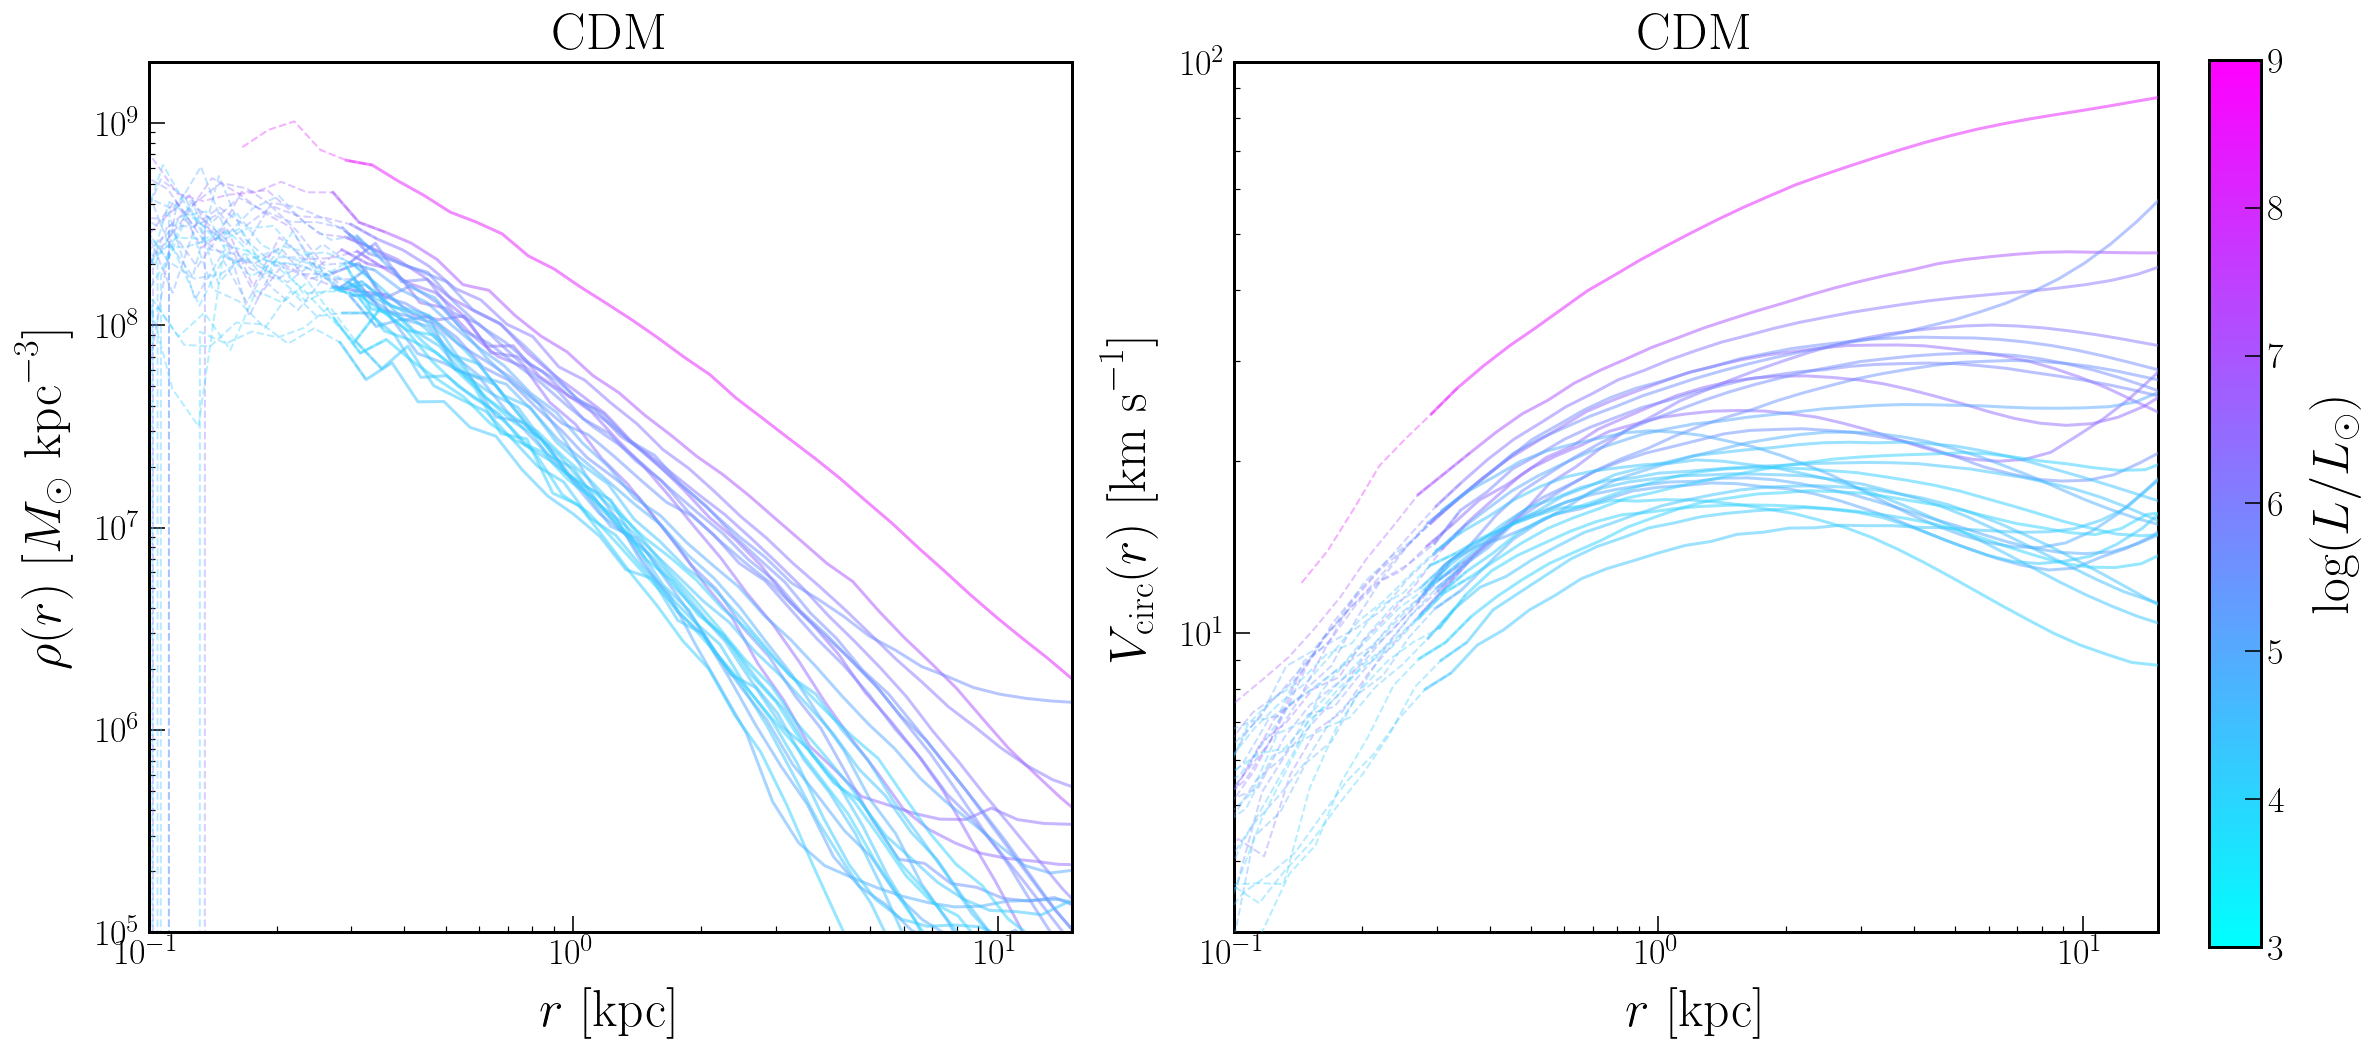

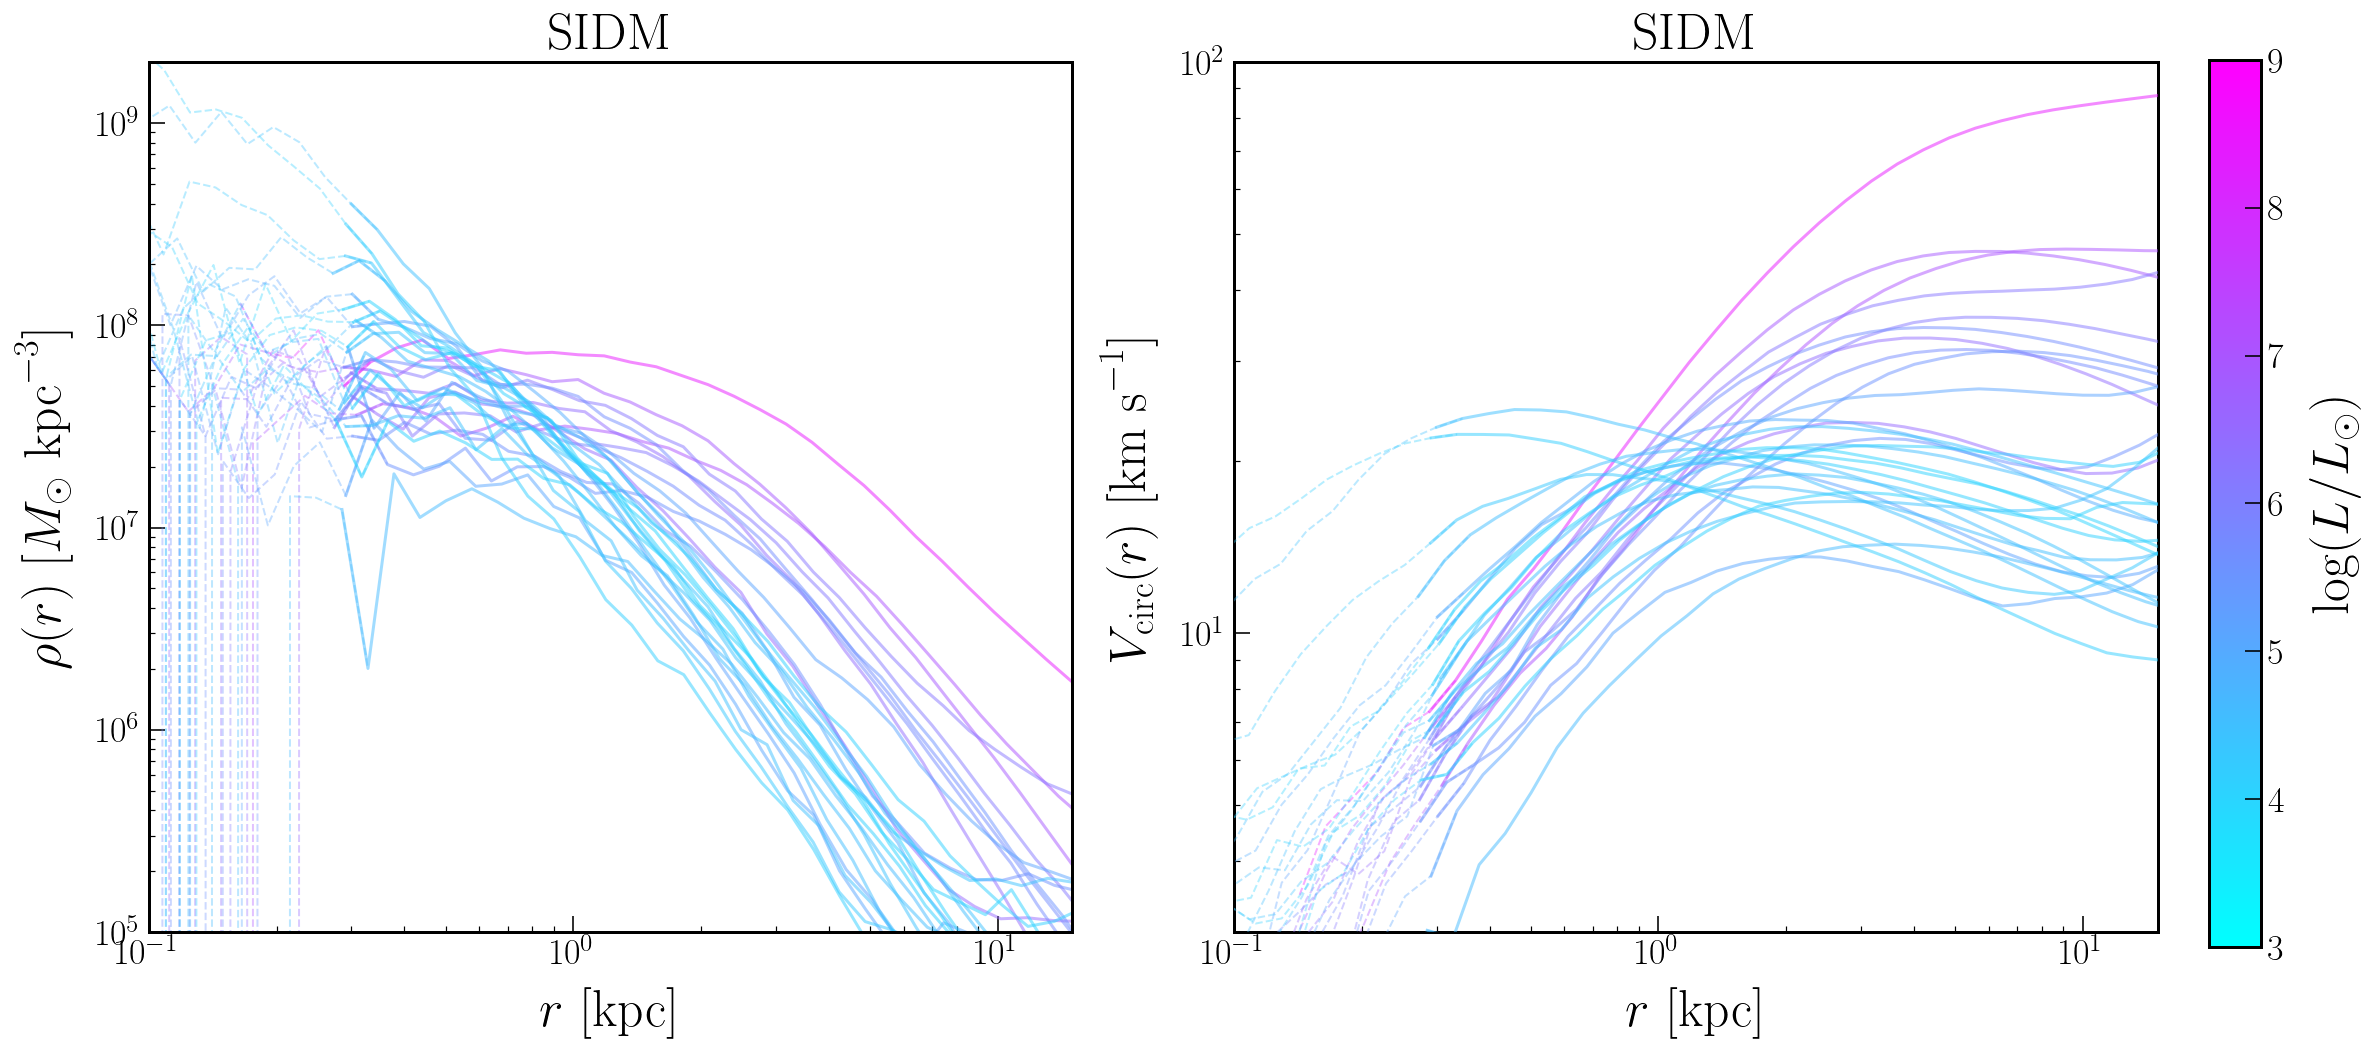

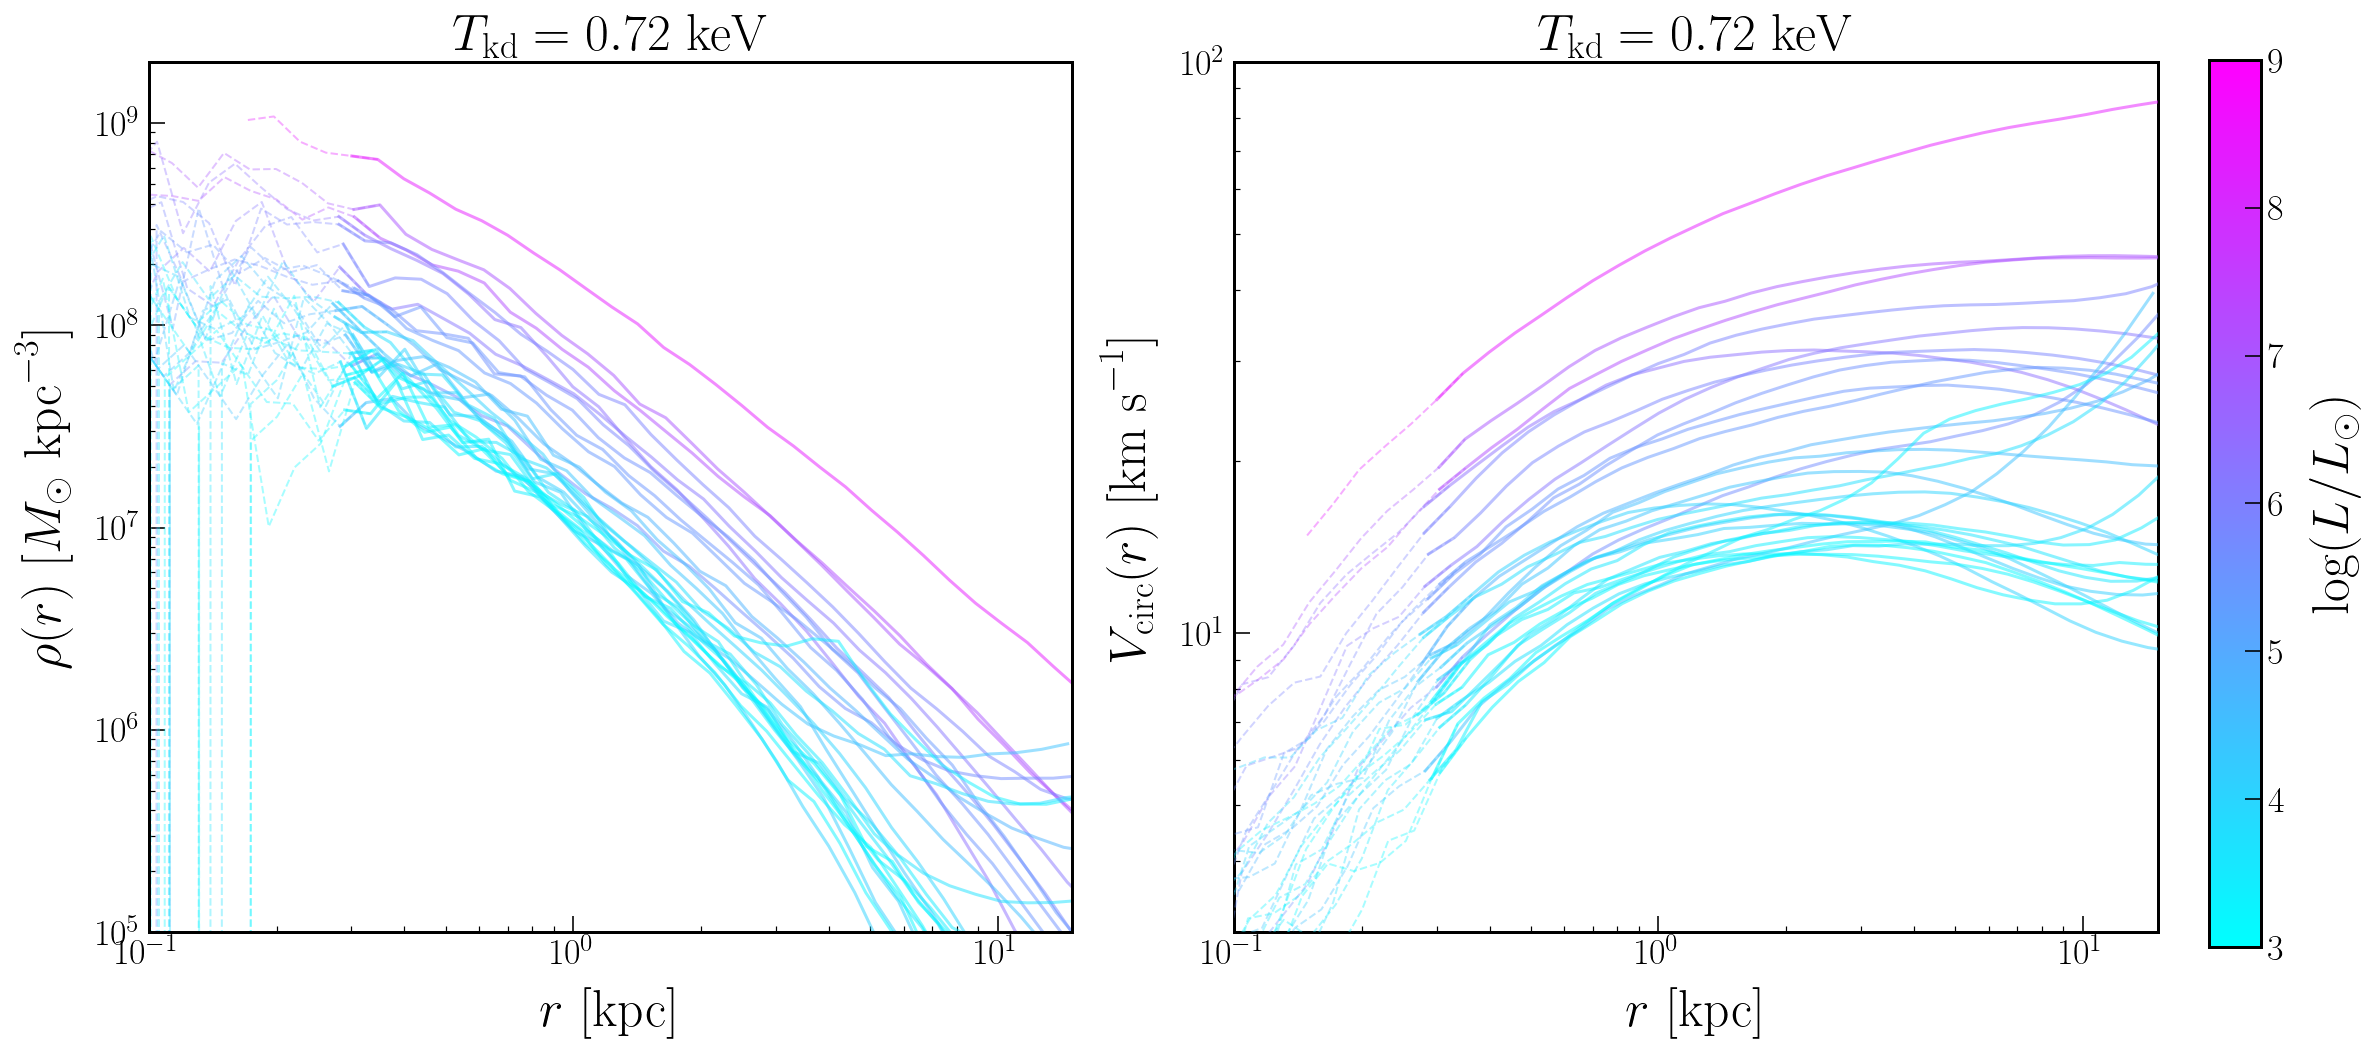

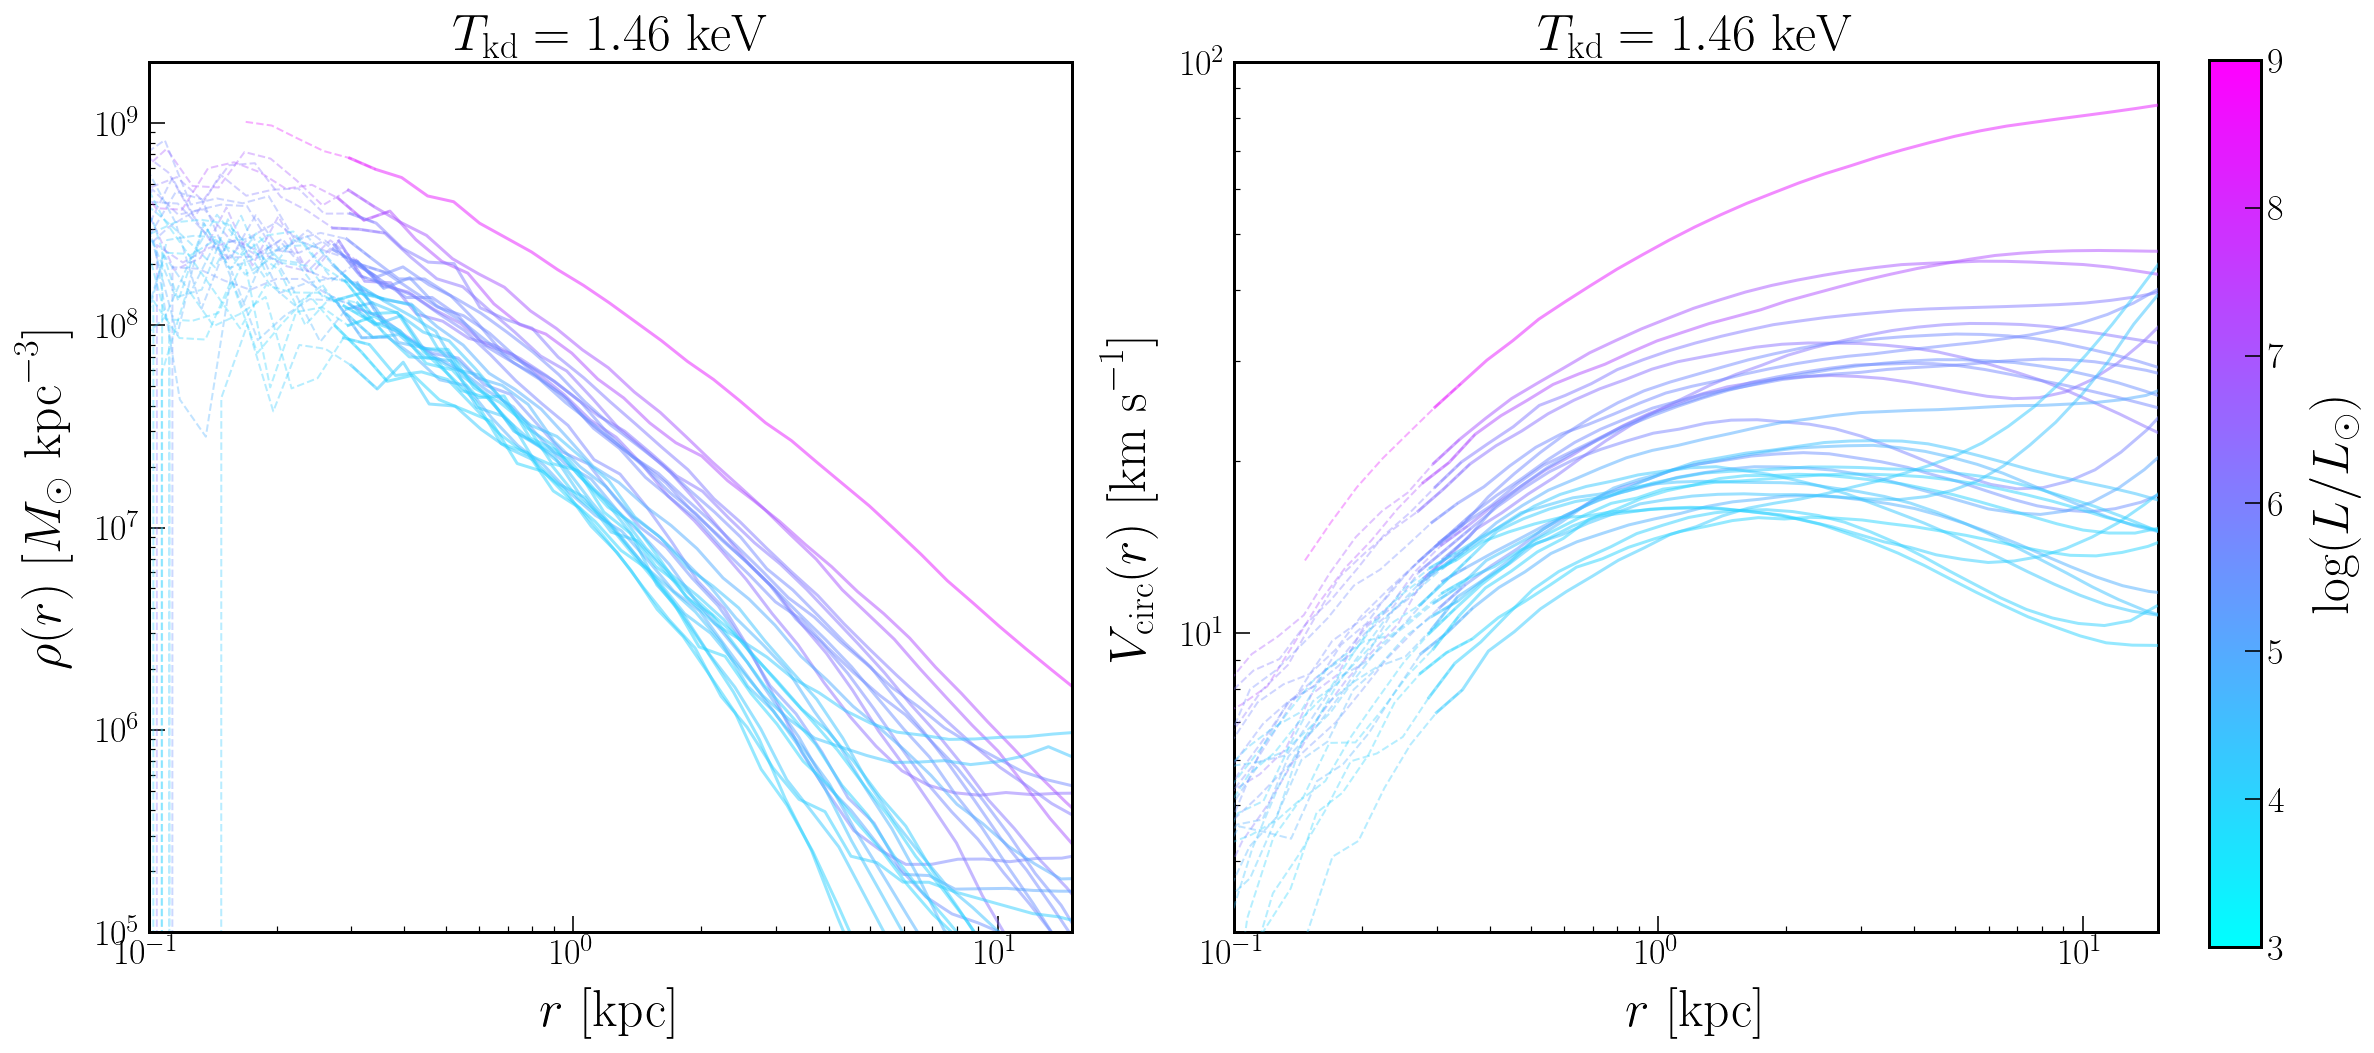

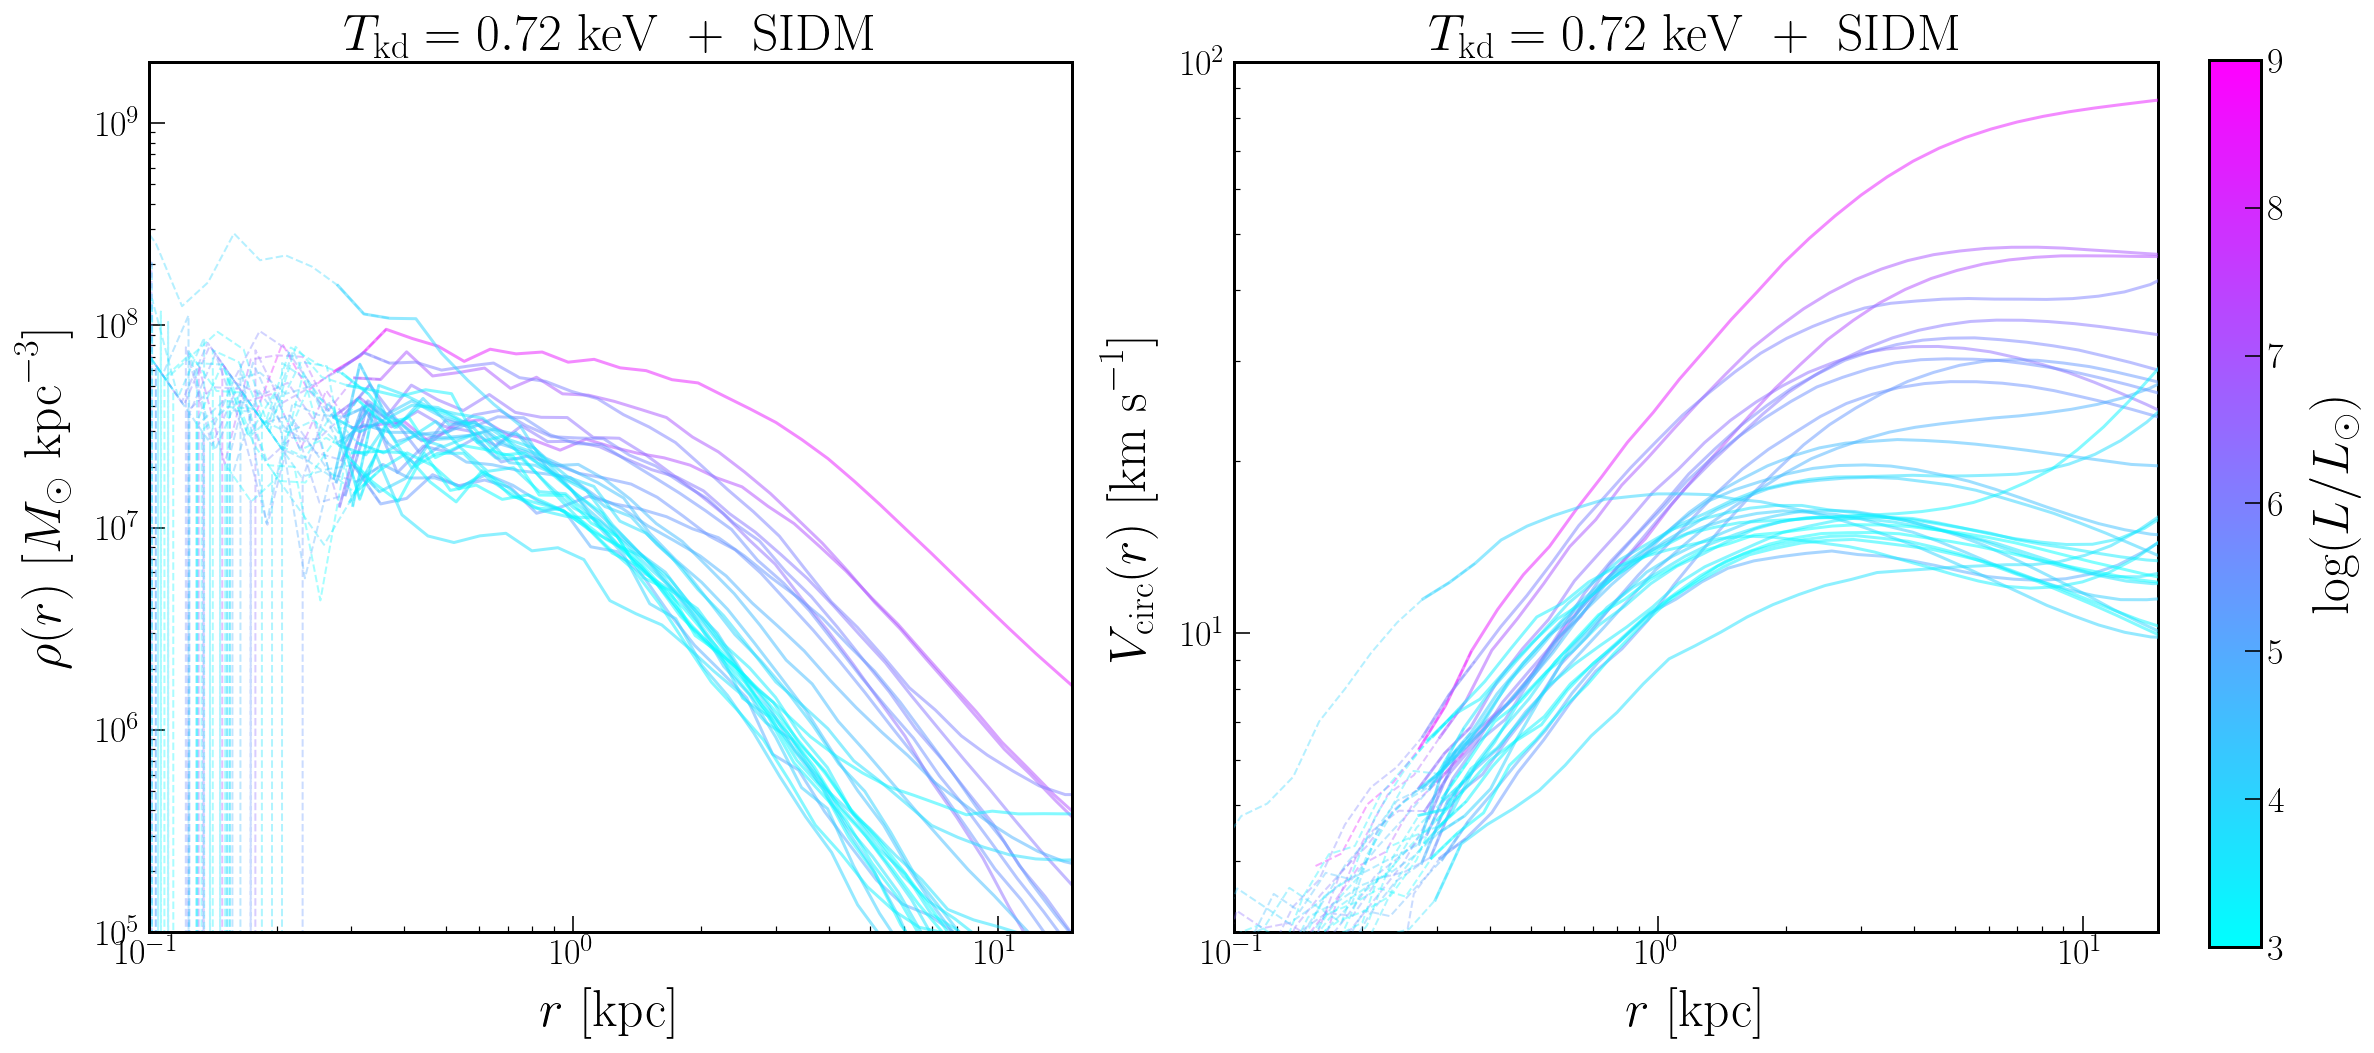

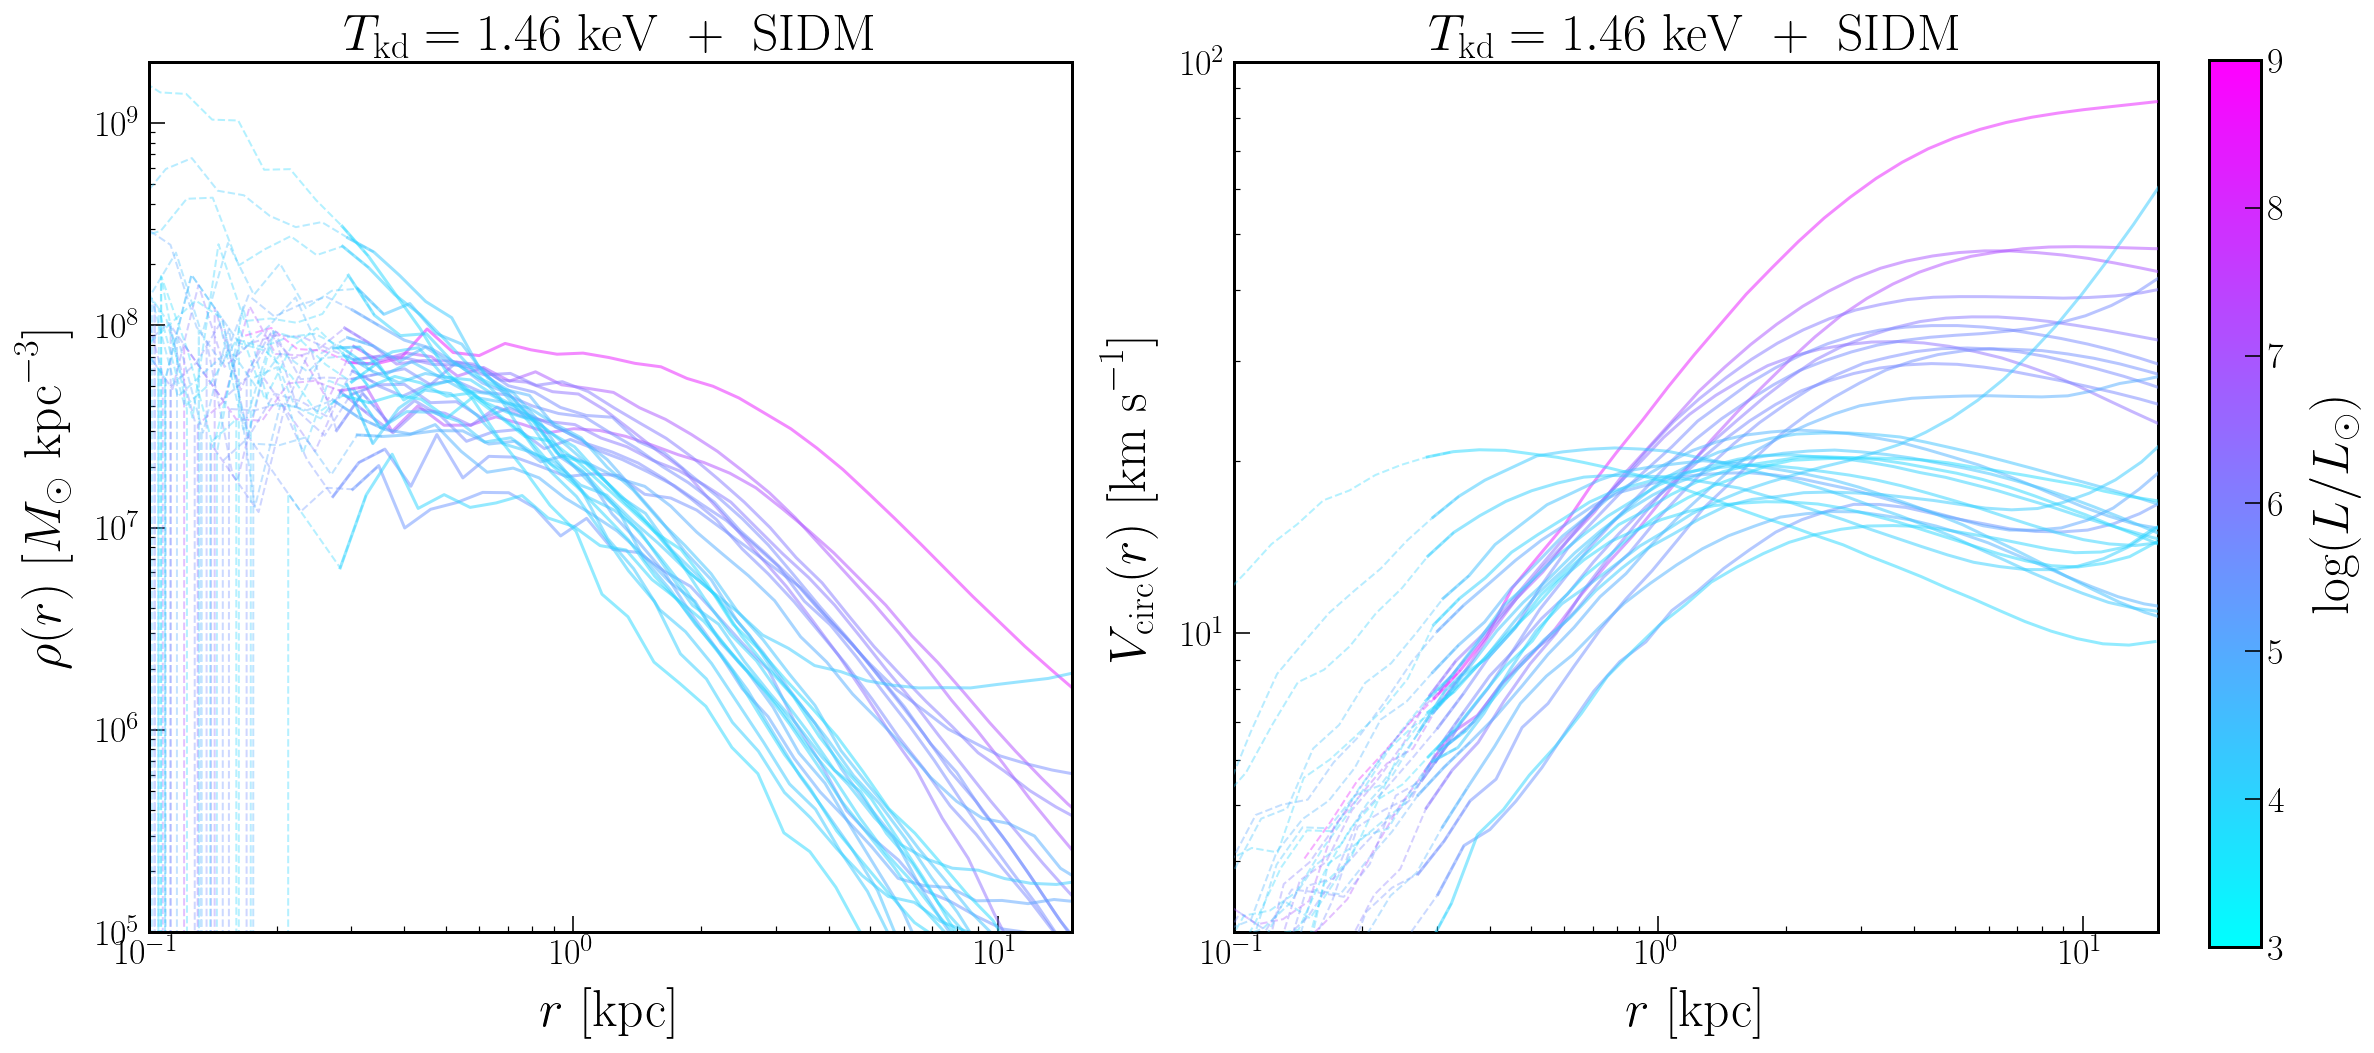

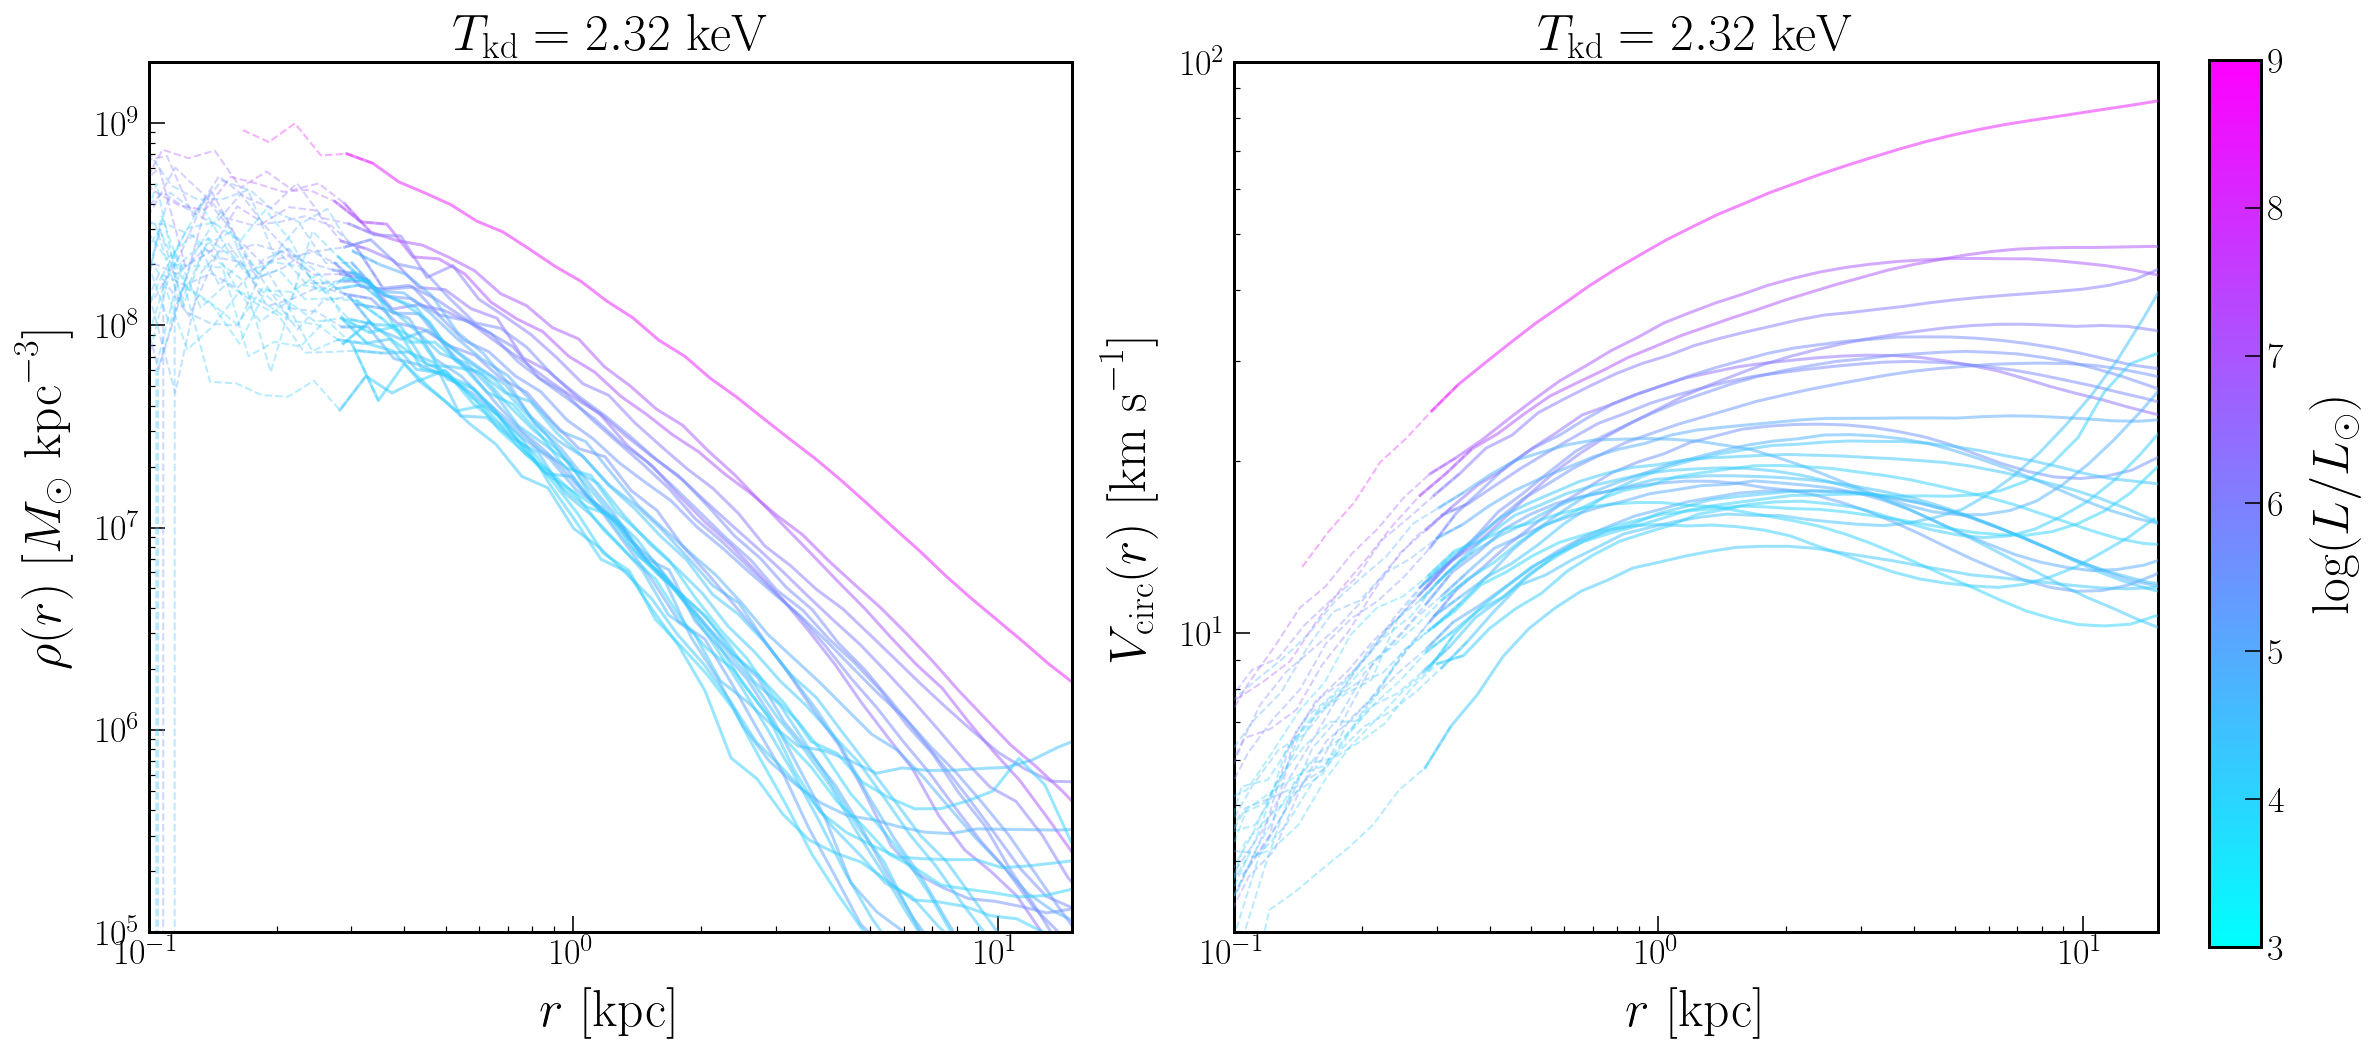

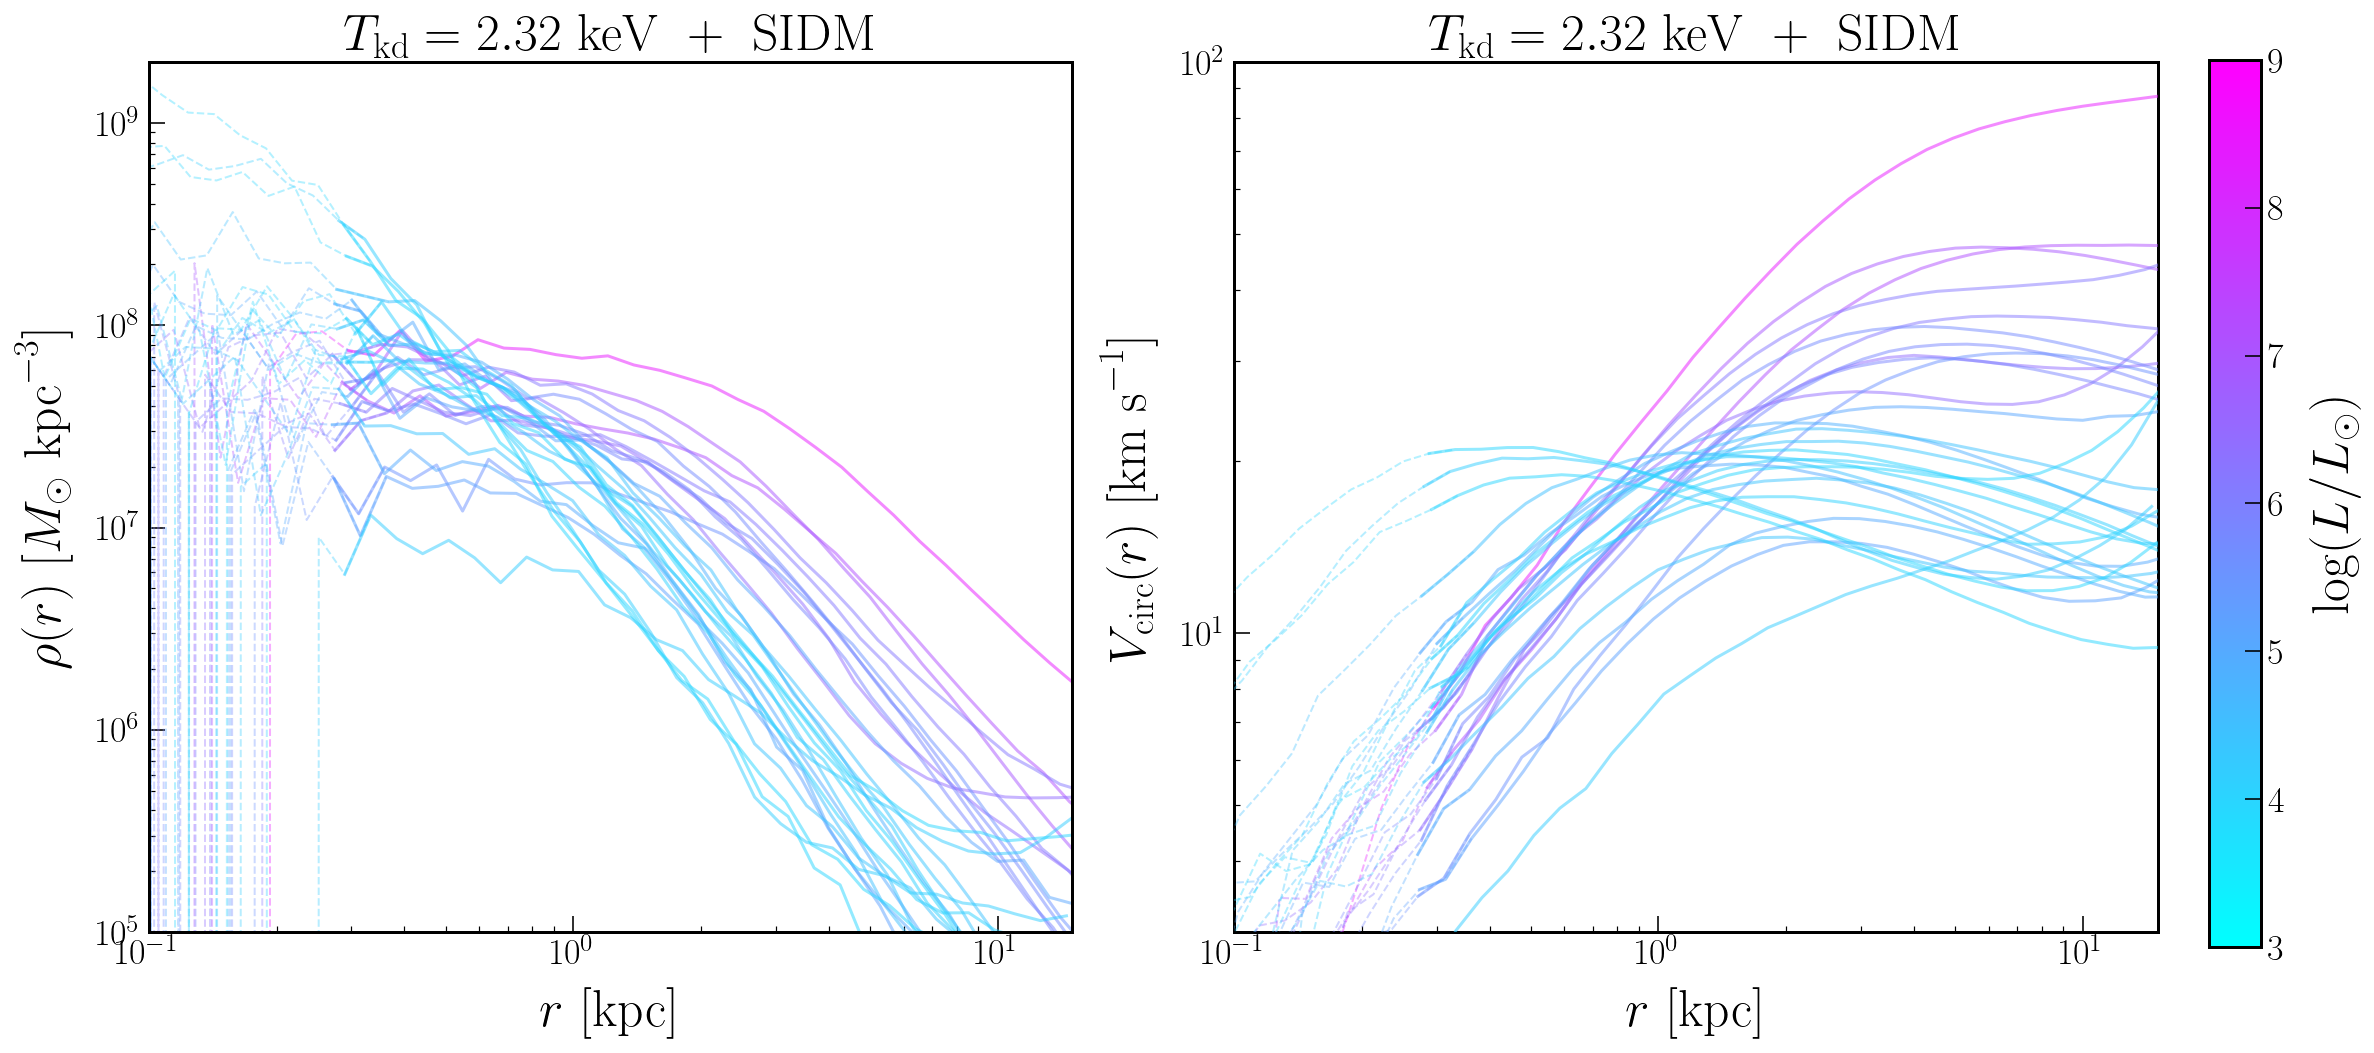

In [4]:
for model in compressed_data.keys():
                    
    ids = np.array(ids_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
    Vpeak = np.array(Vpeak_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
    L = np.array(L_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
            
    cmap = cm.cool
    norm = Normalize(vmin=3., vmax=9.)
    
    ###
    
    fig  = plt.figure(figsize=(18,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.175)
    ax1 = fig.add_subplot(gs[0])
        
    ###
    
    for i,key in enumerate(ids):
        if (compressed_data[model][key]['Vmax'] > Vmax_lower) & (compressed_data[model][key]['Vmax'] < Vmax_upper) & (compressed_data[model][key]['Mvir']>1.2e8):
            r_diff = np.concatenate((np.array([compressed_data[model][key]['r_bins'][0]**3]),
                                    np.diff(compressed_data[model][key]['r_bins']**3)))
            density = compressed_data[model][key]['Mshell'][1:]/(4.*np.pi*r_diff[1:]/3.)
            ind = compressed_data[model][key]['r_bins']/0.7 >= 0.27
            nind = compressed_data[model][key]['r_bins']/0.7 < 0.37
            ax1.loglog((compressed_data[model][key]['r_bins'])[1:][ind[1:]]/0.7,density[ind[1:]],
                         c=cmap(norm(np.log10(L[i][0]))),lw=1.5,alpha=0.5)
            ax1.loglog((compressed_data[model][key]['r_bins'])[1:][nind[1:]]/0.7,density[nind[1:]],
                         c=cmap(norm(np.log10(L[i][0]))),lw=1.,ls='--',alpha=0.35)
    
    ax1.set_xlim(0.1,15)
    ax1.set_ylim(1e5,2e9)
    
    ax1.set_xticks([1e-1,1e-0,1e1])
    ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$'],fontsize=18)
    ax1.set_yticks([1e5,1e6,1e7,1e8,1e9])
    ax1.set_yticklabels([r'$10^{5}$',r'$10^{6}$',r'$10^{7}$',r'$10^{8}$',r'$10^{9}$'],fontsize=18)
    ax1.set_xlabel(r'$r\ [\mathrm{kpc}]$',fontsize=26,labelpad=8)
    ax1.set_ylabel(r'$\rho(r)\ [M_{\mathrm{\odot}}\ \mathrm{kpc}^{-3}]$',fontsize=26,labelpad=12)
    ax1.set_title(labels[model],fontsize=26)
    
    ###
    
    ax2 = fig.add_subplot(gs[1])

    ids = np.array(ids_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
    Vpeak = np.array(Vpeak_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
    L = np.array(L_all[model])[np.argsort(np.ravel(Vpeak_all[model]))[::-1][0:30]]
            
    for i,key in enumerate(ids):
        if (compressed_data[model][key]['Vmax'] > Vmax_lower) & (compressed_data[model][key]['Vmax'] < Vmax_upper) & (compressed_data[model][key]['Mvir']>1.2e8):
            r_diff = np.concatenate((np.array([compressed_data[model][key]['r_bins'][0]**3]),
                                    np.diff(compressed_data[model][key]['r_bins']**3)))
            density = compressed_data[model][key]['Mshell'][1:]/(4.*np.pi*r_diff[1:]/3.)
            ind = compressed_data[model][key]['r_bins']/0.7 >= 0.27
            nind = compressed_data[model][key]['r_bins']/0.7 < 0.37
            ax2.plot(compressed_data[model][key]['r_bins'][ind]/0.7,
                     kpc_to_km*np.sqrt(G*compressed_data[model][key]['Menc']/(compressed_data[model][key]['r_bins']))[ind],
                         c=cmap(norm(np.log10(L[i][0]))),alpha=0.5,lw=1.5,zorder=998)
            ax2.plot(compressed_data[model][key]['r_bins'][nind]/0.7,
                     kpc_to_km*np.sqrt(G*compressed_data[model][key]['Menc']/(compressed_data[model][key]['r_bins']))[nind],
                         c=cmap(norm(np.log10(L[i][0]))),ls='--',alpha=0.35,lw=1.,zorder=998)
   
    ax2.set_xticks([2,4,6,8,10,12,14])
    ax2.set_xticklabels([r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$'],fontsize=18)
    ax2.set_yticks([10,100])
    ax2.set_yticklabels([r'$10$',r'$100$'],fontsize=18)
    ax2.set_xlim(0.1,15)
    ax2.set_ylim(3,100)
    
    ax2.set_xlabel(r'$r\ [\mathrm{kpc}]$',fontsize=26,labelpad=8)
    ax2.set_ylabel(r'$V_{\mathrm{circ}}(r)\ [\mathrm{km\ s}^{-1}]$',fontsize=26,labelpad=12)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title(labels[model],fontsize=26)

    cbar_ax = fig.add_axes([0.92, 0.112, 0.02, 0.77])
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(r'$\log(L/L_{\odot})$', fontsize=26,labelpad=12)
    cbar.set_ticks([3,4,5,6,7,8,9])
    cbar.ax.tick_params(labelsize=18)
    
    plt.show()